<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU_AE/GRU_AE_Corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [ ]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 1.77 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [ ]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [ ]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [ ]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [ ]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [ ]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 20 09:23:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [ ]:
# storing the file to be read as a string
in_str = 'Corn'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU_AE'
# setting our window_length to be 30 days
window_len = 30

In [ ]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [ ]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8 MB 4.3 MB/s 
     |████████████████████████████████| 170 kB 53.6 MB/s 
     |████████████████████████████████| 97 kB 8.9 MB/s 
     |████████████████████████████████| 138 kB 60.8 MB/s 
     |████████████████████████████████| 133 kB 52.6 MB/s 
     |████████████████████████████████| 63 kB 2.2 MB/s 
     |████████████████████████████████| 62 kB 1.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
!pip install wandb -qq

In [ ]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu']
        }
    }
}

In [ ]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

     # layer 1
    model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, return_sequences=False, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 3
    model.add(RepeatVector(window_len))
    # layer 4
    model.add(GRU(units=64, return_sequences=True, activation=config.activation))
    model.add(Dropout(config.dropout))
    # layer 5
    model.add(GRU(units=128, return_sequences=False, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 6
    model.add((Dense(1)))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [ ]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: c40v0fij
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU_AE/sweeps/c40v0fij


In [ ]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: ip1nkt93 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/200
8/8 [==============================] - 30s 550ms/step - loss: 0.7625 - mean_squared_error: 0.7625 - mean_absolute_error: 0.6159 - val_loss: 0.1033 - val_mean_squared_error: 0.1033 - val_mean_absolute_error: 0.2642
Epoch 2/200
8/8 [==============================] - 2s 273ms/step - loss: 0.0323 - mean_squared_error: 0.0323 - mean_absolute_error: 0.1239 - val_loss: 0.0292 - val_mean_squared_error: 0.0292 - val_mean_absolute_error: 0.1344
Epoch 3/200
8/8 [==============================] - 2s 263ms/step - loss: 0.0198 - mean_squared_error: 0.0198 - mean_absolute_error: 0.1064 - val_loss: 0.0273 - val_mean_squared_error: 0.0273 - val_mean_absolute_error: 0.1374
Epoch 4/200
8/8 [==============================] - 2s 271ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0829 - val_loss: 0.0815 - val_mean_squared_error: 0.0815 - val_mean_absolute_error: 0.2439
Epoch 5/200
8/8 [==============================] - 2s 270ms/step - loss: 0.0169 - mean_squared_erro

epoch,35
loss,0.00383
mean_squared_error,0.00383
mean_absolute_error,0.04704
val_loss,0.01674
val_mean_squared_error,0.01674
val_mean_absolute_error,0.10644
_runtime,112
_timestamp,1626773249
_step,35
best_val_loss,0.00792


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▂▂▅█▂▂▁▃▂▄▁▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▂▂
val_mean_squared_error,▆▂▂▅█▂▂▁▃▂▄▁▁▂▁▁▁▁▁▁▁▁▁▂▂▁▁▁▁▂▁▁▁▁▂▂
val_mean_absolute_error,▇▃▃▆█▃▃▁▄▂▅▁▂▃▁▂▁▂▂▁▁▁▁▃▂▁▂▁▁▃▁▁▁▂▂▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: eroeznw8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/100
31/31 [==============================] - 17s 323ms/step - loss: 0.0750 - mean_squared_error: 0.0750 - mean_absolute_error: 0.2118 - val_loss: 0.0194 - val_mean_squared_error: 0.0194 - val_mean_absolute_error: 0.1130
Epoch 2/100
31/31 [==============================] - 8s 260ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0451 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0892
Epoch 3/100
31/31 [==============================] - 8s 243ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - mean_absolute_error: 0.0486 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0837
Epoch 4/100
31/31 [==============================] - 8s 248ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0402 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0838
Epoch 5/100
31/31 [==============================] - 8s 243ms/step - loss: 0.0026 - mean_sq

epoch,63
loss,0.00117
mean_squared_error,0.00117
mean_absolute_error,0.02596
val_loss,0.00588
val_mean_squared_error,0.00588
val_mean_absolute_error,0.05952
_runtime,505
_timestamp,1626773765
_step,63
best_val_loss,0.00466


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▂▁▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▅▄▃▃▃▃▂▂▂▂▂▂▂▁▁▂▁▁▂▂▂▂▁▁▁▁▁▁▂▃▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▅▅▄▄▃▄▂▃▃▃▃▃▃▂▁▂▁▁▂▂▃▂▁▁▁▁▁▂▂▄▁▁▁▁▂▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: rhbg7eng with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 11s 345ms/step - loss: 0.0859 - mean_squared_error: 0.0859 - mean_absolute_error: 0.2202 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1339
Epoch 2/50
16/16 [==============================] - 4s 252ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0669 - val_loss: 0.0202 - val_mean_squared_error: 0.0202 - val_mean_absolute_error: 0.1154
Epoch 3/50
16/16 [==============================] - 4s 235ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0531 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0928
Epoch 4/50
16/16 [==============================] - 4s 243ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0519 - val_loss: 0.0130 - val_mean_squared_error: 0.0130 - val_mean_absolute_error: 0.0911
Epoch 5/50
16/16 [==============================] - 4s 242ms/step - loss: 0.0054 - mean_squared

epoch,49
loss,0.00257
mean_squared_error,0.00257
mean_absolute_error,0.03749
val_loss,0.01051
val_mean_squared_error,0.01051
val_mean_absolute_error,0.08341
_runtime,211
_timestamp,1626773988
_step,49
best_val_loss,0.00667


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅▃▃▅▃▅█▄▃▂▂▂▂▂▅▄▂▂▂▁▂▁▁▁▂▂▁▂▂▁▂▁▁▁▂▁▂▂▂
val_mean_squared_error,▇▅▃▃▅▃▅█▄▃▂▂▂▂▂▅▄▂▂▂▁▂▁▁▁▂▂▁▂▂▁▂▁▁▁▂▁▂▂▂
val_mean_absolute_error,▇▅▄▃▆▃▅█▅▄▃▂▂▃▂▆▅▂▂▂▁▃▁▂▂▂▂▂▂▂▁▂▁▁▁▂▂▂▂▃
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 3gtu77x5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
31/31 [==============================] - 10s 55ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - mean_absolute_error: 0.1375 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0885
Epoch 2/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0745 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0808
Epoch 3/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0558 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1120
Epoch 4/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0593 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0942
Epoch 5/200
31/31 [==============================] - 0s 13ms/step - loss: 0.0062 - mean_squared

epoch,37
loss,0.00152
mean_squared_error,0.00152
mean_absolute_error,0.0297
val_loss,0.00518
val_mean_squared_error,0.00518
val_mean_absolute_error,0.05435
_runtime,32
_timestamp,1626774032
_step,37
best_val_loss,0.00433


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▄▄▃▃▃▃▃▂▂▂▁▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁
val_loss,▄▃▅▄▂█▇▄▂▅▂▃▂▁▂▁▄▁▁▂▂▁▁▁▁▄▂▁▁▁▂▁▂▁▁▁▁▁
val_mean_squared_error,▄▃▅▄▂█▇▄▂▅▂▃▂▁▂▁▄▁▁▂▂▁▁▁▁▄▂▁▁▁▂▁▂▁▁▁▁▁
val_mean_absolute_error,▄▄▆▅▂██▅▂▆▃▄▂▁▃▂▅▁▂▃▂▁▁▁▁▅▂▁▂▁▃▁▂▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: e755ryk9 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 12s 361ms/step - loss: 0.0604 - mean_squared_error: 0.0604 - mean_absolute_error: 0.1747 - val_loss: 0.0224 - val_mean_squared_error: 0.0224 - val_mean_absolute_error: 0.1243
Epoch 2/200
16/16 [==============================] - 4s 248ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0626 - val_loss: 0.0123 - val_mean_squared_error: 0.0123 - val_mean_absolute_error: 0.0888
Epoch 3/200
16/16 [==============================] - 4s 240ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0468 - val_loss: 0.0085 - val_mean_squared_error: 0.0085 - val_mean_absolute_error: 0.0706
Epoch 4/200
16/16 [==============================] - 4s 243ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0352 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0734
Epoch 5/200
16/16 [==============================] - 4s 244ms/step - loss: 0.0026 - mean_sq

epoch,45
loss,0.00143
mean_squared_error,0.00143
mean_absolute_error,0.02782
val_loss,0.00472
val_mean_squared_error,0.00472
val_mean_absolute_error,0.05104
_runtime,199
_timestamp,1626774262
_step,45
best_val_loss,0.00444


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▃▃▃▂▂▃▂▁▁▁▂▂▂▁▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████


wandb: Agent Starting Run: orym26y6 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
16/16 [==============================] - 7s 101ms/step - loss: 0.5481 - mean_squared_error: 0.5481 - mean_absolute_error: 0.5209 - val_loss: 0.0291 - val_mean_squared_error: 0.0291 - val_mean_absolute_error: 0.1351
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0171 - mean_squared_error: 0.0171 - mean_absolute_error: 0.0957 - val_loss: 0.0989 - val_mean_squared_error: 0.0989 - val_mean_absolute_error: 0.2820
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0259 - mean_squared_error: 0.0259 - mean_absolute_error: 0.1295 - val_loss: 0.0373 - val_mean_squared_error: 0.0373 - val_mean_absolute_error: 0.1683
Epoch 4/50
16/16 [==============================] - 0s 17ms/step - loss: 0.0212 - mean_squared_error: 0.0212 - mean_absolute_error: 0.1091 - val_loss: 0.0663 - val_mean_squared_error: 0.0663 - val_mean_absolute_error: 0.2265
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0396 - mean_squared_erro

epoch,30
loss,0.0038
mean_squared_error,0.0038
mean_absolute_error,0.04832
val_loss,0.01648
val_mean_squared_error,0.01648
val_mean_absolute_error,0.10456
_runtime,22
_timestamp,1626774295
_step,30
best_val_loss,0.00562


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▃▂▃▂▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁
val_loss,▃█▃▆▅▂▃▄▃▅▇▁▄▁▃▃▇▁▂▁▁▃▁▂▁▁▁▁▂▁▂
val_mean_squared_error,▃█▃▆▅▂▃▄▃▅▇▁▄▁▃▃▇▁▂▁▁▃▁▂▁▁▁▁▂▁▂
val_mean_absolute_error,▃█▄▆▅▃▄▅▄▅▆▁▄▁▄▄▇▂▂▁▁▄▁▃▂▁▁▂▃▁▃
_runtime,▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
_timestamp,▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: cfq0pngk with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 12s 350ms/step - loss: 0.1198 - mean_squared_error: 0.1198 - mean_absolute_error: 0.2886 - val_loss: 0.0275 - val_mean_squared_error: 0.0275 - val_mean_absolute_error: 0.1306
Epoch 2/50
16/16 [==============================] - 4s 255ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1322 - val_loss: 0.0477 - val_mean_squared_error: 0.0477 - val_mean_absolute_error: 0.1777
Epoch 3/50
16/16 [==============================] - 4s 250ms/step - loss: 0.0149 - mean_squared_error: 0.0149 - mean_absolute_error: 0.0833 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1137
Epoch 4/50
16/16 [==============================] - 4s 251ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0576 - val_loss: 0.0125 - val_mean_squared_error: 0.0125 - val_mean_absolute_error: 0.0888
Epoch 5/50
16/16 [==============================] - 4s 234ms/step - loss: 0.0049 - mean_squared

epoch,18
loss,0.00351
mean_squared_error,0.00351
mean_absolute_error,0.0437
val_loss,0.01254
val_mean_squared_error,0.01254
val_mean_absolute_error,0.08917
_runtime,90
_timestamp,1626774397
_step,18
best_val_loss,0.01207


epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄█▃▁▁▁▁▁▁▁▂▁▁▂▂▁▁▃▁
val_mean_squared_error,▄█▃▁▁▁▁▁▁▁▂▁▁▂▂▁▁▃▁
val_mean_absolute_error,▄█▃▁▂▁▂▁▁▁▂▁▁▂▃▂▁▃▁
_runtime,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▇▇▇██
_step,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██


wandb: Agent Starting Run: y8420a7p with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 12s 520ms/step - loss: 0.1236 - mean_squared_error: 0.1236 - mean_absolute_error: 0.2984 - val_loss: 0.0376 - val_mean_squared_error: 0.0376 - val_mean_absolute_error: 0.1536
Epoch 2/200
8/8 [==============================] - 2s 287ms/step - loss: 0.0175 - mean_squared_error: 0.0175 - mean_absolute_error: 0.1013 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1175
Epoch 3/200
8/8 [==============================] - 2s 266ms/step - loss: 0.0090 - mean_squared_error: 0.0090 - mean_absolute_error: 0.0725 - val_loss: 0.0138 - val_mean_squared_error: 0.0138 - val_mean_absolute_error: 0.0938
Epoch 4/200
8/8 [==============================] - 2s 266ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0676 - val_loss: 0.0247 - val_mean_squared_error: 0.0247 - val_mean_absolute_error: 0.1308
Epoch 5/200
8/8 [==============================] - 2s 255ms/step - loss: 0.0053 - mean_squared_erro

epoch,39
loss,0.0032
mean_squared_error,0.0032
mean_absolute_error,0.04194
val_loss,0.01063
val_mean_squared_error,0.01063
val_mean_absolute_error,0.08206
_runtime,99
_timestamp,1626774519
_step,39
best_val_loss,0.00946


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁
val_loss,█▄▂▅▄▂▁▁▁▃▃▄▃▅▃▄▁▅▂▃▂▁▁▂▇▂▃▄▄▁▂▃▂▃▂▂▂▂▁▁
val_mean_squared_error,█▄▂▅▄▂▁▁▁▃▃▄▃▅▃▄▁▅▂▃▂▁▁▂▇▂▃▄▄▁▂▃▂▃▂▂▂▂▁▁
val_mean_absolute_error,█▅▃▆▆▃▂▂▁▃▄▅▄▆▃▅▁▆▂▄▂▁▂▂█▂▄▅▅▁▂▄▂▄▂▂▃▃▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: kpmko4us with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 7s 106ms/step - loss: 0.0751 - mean_squared_error: 0.0751 - mean_absolute_error: 0.2171 - val_loss: 0.0307 - val_mean_squared_error: 0.0307 - val_mean_absolute_error: 0.1426
Epoch 2/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0119 - mean_squared_error: 0.0119 - mean_absolute_error: 0.0738 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0890
Epoch 3/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0563 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0824
Epoch 4/100
16/16 [==============================] - 0s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0444 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0813
Epoch 5/100
16/16 [==============================] - 0s 15ms/step - loss: 0.0045 - mean_squared

epoch,99
loss,0.00142
mean_squared_error,0.00142
mean_absolute_error,0.02716
val_loss,0.0047
val_mean_squared_error,0.0047
val_mean_absolute_error,0.04978
_runtime,44
_timestamp,1626774575
_step,99
best_val_loss,0.00451


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: oy16tc0i with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
31/31 [==============================] - 7s 58ms/step - loss: 0.0669 - mean_squared_error: 0.0669 - mean_absolute_error: 0.1903 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0949
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0597 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0869
Epoch 3/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0396 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0819
Epoch 4/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0397 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0828
Epoch 5/50
31/31 [==============================] - 0s 15ms/step - loss: 0.0028 - mean_squared_error

epoch,49
loss,0.00154
mean_squared_error,0.00154
mean_absolute_error,0.02827
val_loss,0.00452
val_mean_squared_error,0.00452
val_mean_absolute_error,0.04795
_runtime,36
_timestamp,1626774651
_step,49
best_val_loss,0.00451


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▆▅▄▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▆▅▄▄▃▃▃▃▂▂▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: aomswell with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 12s 356ms/step - loss: 0.0984 - mean_squared_error: 0.0984 - mean_absolute_error: 0.2499 - val_loss: 0.0244 - val_mean_squared_error: 0.0244 - val_mean_absolute_error: 0.1275
Epoch 2/200
16/16 [==============================] - 4s 243ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0806 - val_loss: 0.0158 - val_mean_squared_error: 0.0158 - val_mean_absolute_error: 0.1006
Epoch 3/200
16/16 [==============================] - 4s 257ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0534 - val_loss: 0.0146 - val_mean_squared_error: 0.0146 - val_mean_absolute_error: 0.0968
Epoch 4/200
16/16 [==============================] - 4s 259ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0465 - val_loss: 0.0218 - val_mean_squared_error: 0.0218 - val_mean_absolute_error: 0.1223
Epoch 5/200
16/16 [==============================] - 4s 241ms/step - loss: 0.0041 - mean_sq

epoch,76
loss,0.00164
mean_squared_error,0.00164
mean_absolute_error,0.03009
val_loss,0.00689
val_mean_squared_error,0.00689
val_mean_absolute_error,0.06496
_runtime,328
_timestamp,1626775011
_step,76
best_val_loss,0.00515


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▇▃▃▂▃▂▂▂▆▂▂▂▅▂▂▁▂▂▂▂▁▂▂▂▂▃▂▂▃▁▁▃▁▂▁▁▂▂
val_mean_squared_error,█▅▇▃▃▂▃▂▂▂▆▂▂▂▅▂▂▁▂▂▂▂▁▂▂▂▂▃▂▂▃▁▁▃▁▂▁▁▂▂
val_mean_absolute_error,█▅█▄▄▃▄▃▃▂▇▃▂▂▆▃▃▂▃▂▂▃▁▂▂▂▂▄▂▃▃▁▁▄▁▃▂▁▃▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dnwlf707 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 17s 288ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1732 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1276
Epoch 2/50
31/31 [==============================] - 7s 238ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0633 - val_loss: 0.0135 - val_mean_squared_error: 0.0135 - val_mean_absolute_error: 0.0940
Epoch 3/50
31/31 [==============================] - 8s 245ms/step - loss: 0.0063 - mean_squared_error: 0.0063 - mean_absolute_error: 0.0582 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0787
Epoch 4/50
31/31 [==============================] - 7s 239ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0548 - val_loss: 0.0249 - val_mean_squared_error: 0.0249 - val_mean_absolute_error: 0.1343
Epoch 5/50
31/31 [==============================] - 7s 236ms/step - loss: 0.0056 - mean_squared

epoch,36
loss,0.00195
mean_squared_error,0.00195
mean_absolute_error,0.03277
val_loss,0.0062
val_mean_squared_error,0.0062
val_mean_absolute_error,0.06033
_runtime,297
_timestamp,1626775323
_step,36
best_val_loss,0.00554


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃█▂▂▂▂▁▃▅▂▁▃▁▂▂▁▁▂▁▆▄▁▁▁▁▁▃▁▁▁▃▁▁▃▁
val_mean_squared_error,█▄▃█▂▂▂▂▁▃▅▂▁▃▁▂▂▁▁▂▁▆▄▁▁▁▁▁▃▁▁▁▃▁▁▃▁
val_mean_absolute_error,▇▄▃█▂▂▂▂▂▄▆▂▁▃▁▃▃▁▁▂▁▆▅▁▂▁▁▁▃▁▁▁▃▁▁▃▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 7fgr8wlh with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
16/16 [==============================] - 13s 381ms/step - loss: 0.1384 - mean_squared_error: 0.1384 - mean_absolute_error: 0.2977 - val_loss: 0.0860 - val_mean_squared_error: 0.0860 - val_mean_absolute_error: 0.2440
Epoch 2/100
16/16 [==============================] - 4s 271ms/step - loss: 0.0224 - mean_squared_error: 0.0224 - mean_absolute_error: 0.1083 - val_loss: 0.0301 - val_mean_squared_error: 0.0301 - val_mean_absolute_error: 0.1402
Epoch 3/100
16/16 [==============================] - 4s 264ms/step - loss: 0.0108 - mean_squared_error: 0.0108 - mean_absolute_error: 0.0794 - val_loss: 0.0278 - val_mean_squared_error: 0.0278 - val_mean_absolute_error: 0.1377
Epoch 4/100
16/16 [==============================] - 4s 247ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1039 - val_loss: 0.0124 - val_mean_squared_error: 0.0124 - val_mean_absolute_error: 0.0868
Epoch 5/100
16/16 [==============================] - 4s 241ms/step - loss: 0.0101 - mean_sq

epoch,30
loss,0.0026
mean_squared_error,0.0026
mean_absolute_error,0.03825
val_loss,0.02085
val_mean_squared_error,0.02085
val_mean_absolute_error,0.12554
_runtime,142
_timestamp,1626775517
_step,30
best_val_loss,0.00632


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
val_loss,▇▃▃▁█▂▅▁▁▂▆▃▂▁▁▁▁▁▁▁▁▁▃▂▁▁▂▁▂▁▂
val_mean_squared_error,▇▃▃▁█▂▅▁▁▂▆▃▂▁▁▁▁▁▁▁▁▁▃▂▁▁▂▁▂▁▂
val_mean_absolute_error,▇▄▃▂█▃▆▁▂▃▇▅▂▁▂▁▁▁▁▁▁▁▄▃▁▂▂▂▃▁▃
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: pbzpi1p5 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
31/31 [==============================] - 17s 326ms/step - loss: 0.0940 - mean_squared_error: 0.0940 - mean_absolute_error: 0.2481 - val_loss: 0.0153 - val_mean_squared_error: 0.0153 - val_mean_absolute_error: 0.0974
Epoch 2/50
31/31 [==============================] - 8s 261ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0569 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0916
Epoch 3/50
31/31 [==============================] - 8s 260ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0456 - val_loss: 0.0110 - val_mean_squared_error: 0.0110 - val_mean_absolute_error: 0.0818
Epoch 4/50
31/31 [==============================] - 8s 243ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - mean_absolute_error: 0.0467 - val_loss: 0.0142 - val_mean_squared_error: 0.0142 - val_mean_absolute_error: 0.0955
Epoch 5/50
31/31 [==============================] - 7s 242ms/step - loss: 0.0032 - mean_squared

epoch,46
loss,0.00157
mean_squared_error,0.00157
mean_absolute_error,0.02906
val_loss,0.00784
val_mean_squared_error,0.00784
val_mean_absolute_error,0.07093
_runtime,378
_timestamp,1626775908
_step,46
best_val_loss,0.00573


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▇▄▄▅▅▃▅▃▂▂▃▂▂▃▄▆▅▂▂▂▂▂▁▄▁▄▂▁▁▁▂▁▂▃▂▂▃
val_mean_squared_error,█▆▅▇▄▄▅▅▃▅▃▂▂▃▂▂▃▄▆▅▂▂▂▂▂▁▄▁▄▂▁▁▁▂▁▂▃▂▂▃
val_mean_absolute_error,█▇▅█▅▅▅▆▃▅▃▃▃▃▂▂▃▅▇▆▂▂▂▃▃▂▅▁▅▂▁▁▁▂▁▂▄▂▃▄
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gofbx0yd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 7s 277ms/step - loss: 1.0427 - mean_squared_error: 1.0427 - mean_absolute_error: 0.7676 - val_loss: 0.0767 - val_mean_squared_error: 0.0767 - val_mean_absolute_error: 0.2183
Epoch 2/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0399 - mean_squared_error: 0.0399 - mean_absolute_error: 0.1437 - val_loss: 0.0383 - val_mean_squared_error: 0.0383 - val_mean_absolute_error: 0.1528
Epoch 3/200
8/8 [==============================] - 0s 17ms/step - loss: 0.0287 - mean_squared_error: 0.0287 - mean_absolute_error: 0.1326 - val_loss: 0.0238 - val_mean_squared_error: 0.0238 - val_mean_absolute_error: 0.1205
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - mean_absolute_error: 0.1140 - val_loss: 0.0172 - val_mean_squared_error: 0.0172 - val_mean_absolute_error: 0.1025
Epoch 5/200
8/8 [==============================] - 0s 18ms/step - loss: 0.0233 - mean_squared_error: 0.

epoch,46
loss,0.00522
mean_squared_error,0.00522
mean_absolute_error,0.05016
val_loss,0.01091
val_mean_squared_error,0.01091
val_mean_absolute_error,0.08939
_runtime,20
_timestamp,1626775954
_step,46
best_val_loss,0.00475


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▂▁▃▂▂▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▃▂▂▆▃▂▂▂█▃▁▄▅▄▁▂▂▁▅▁▁▁▆▅▁▃▁▂▁▁▁▂▁▁▁▂▂▁▁
val_mean_squared_error,▆▃▂▂▆▃▂▂▂█▃▁▄▅▄▁▂▂▁▅▁▁▁▆▅▁▃▁▂▁▁▁▂▁▁▁▂▂▁▁
val_mean_absolute_error,▇▄▃▃▇▄▃▃▄█▅▂▅▆▅▂▃▄▂▆▂▂▁▇▇▁▄▁▃▂▂▁▃▂▂▂▄▃▂▂
_runtime,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6yq6bmrj with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 11s 516ms/step - loss: 0.1224 - mean_squared_error: 0.1224 - mean_absolute_error: 0.3002 - val_loss: 0.0421 - val_mean_squared_error: 0.0421 - val_mean_absolute_error: 0.1632
Epoch 2/200
8/8 [==============================] - 2s 285ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - mean_absolute_error: 0.0990 - val_loss: 0.0239 - val_mean_squared_error: 0.0239 - val_mean_absolute_error: 0.1223
Epoch 3/200
8/8 [==============================] - 2s 284ms/step - loss: 0.0092 - mean_squared_error: 0.0092 - mean_absolute_error: 0.0734 - val_loss: 0.0131 - val_mean_squared_error: 0.0131 - val_mean_absolute_error: 0.0910
Epoch 4/200
8/8 [==============================] - 2s 286ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - mean_absolute_error: 0.0623 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0914
Epoch 5/200
8/8 [==============================] - 2s 279ms/step - loss: 0.0046 - mean_squared_erro

epoch,29
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.03484
val_loss,0.01087
val_mean_squared_error,0.01087
val_mean_absolute_error,0.08222
_runtime,78
_timestamp,1626776046
_step,29
best_val_loss,0.00965


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▁▂▂▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▅▃▁▂▃▄▂▂▂▁▁▃▄▂▂▁▁▁▁▁▂▂▂▃▁▁
val_mean_squared_error,█▄▂▂▅▃▁▂▃▄▂▂▂▁▁▃▄▂▂▁▁▁▁▁▂▂▂▃▁▁
val_mean_absolute_error,█▅▂▂▆▃▂▂▄▆▂▃▂▂▁▄▅▂▂▁▂▂▂▁▂▂▃▄▂▂
_runtime,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_timestamp,▁▁▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: m43zcqtv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 10s 468ms/step - loss: 0.0725 - mean_squared_error: 0.0725 - mean_absolute_error: 0.2089 - val_loss: 0.0184 - val_mean_squared_error: 0.0184 - val_mean_absolute_error: 0.1064
Epoch 2/200
8/8 [==============================] - 2s 260ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.1039 - val_loss: 0.0281 - val_mean_squared_error: 0.0281 - val_mean_absolute_error: 0.1372
Epoch 3/200
8/8 [==============================] - 2s 249ms/step - loss: 0.0083 - mean_squared_error: 0.0083 - mean_absolute_error: 0.0653 - val_loss: 0.0192 - val_mean_squared_error: 0.0192 - val_mean_absolute_error: 0.1131
Epoch 4/200
8/8 [==============================] - 2s 259ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0704 - val_loss: 0.0620 - val_mean_squared_error: 0.0620 - val_mean_absolute_error: 0.2138
Epoch 5/200
8/8 [==============================] - 2s 253ms/step - loss: 0.0115 - mean_squared_erro

epoch,38
loss,0.00502
mean_squared_error,0.00502
mean_absolute_error,0.05315
val_loss,0.00998
val_mean_squared_error,0.00998
val_mean_absolute_error,0.0798
_runtime,96
_timestamp,1626776172
_step,38
best_val_loss,0.00822


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▂▃▃▃▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▂▂▂▁▁▂▂
val_loss,▂▄▂█▂▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▃▁▁▂▂▃▁
val_mean_squared_error,▂▄▂█▂▆▅▂▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▃▁▁▂▂▃▁
val_mean_absolute_error,▃▄▃█▂▆▅▂▂▂▂▁▁▁▁▁▁▂▁▁▂▃▂▂▁▁▁▁▁▂▁▁▄▁▂▃▂▃▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: g1oh2up3 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 8s 103ms/step - loss: 0.0860 - mean_squared_error: 0.0860 - mean_absolute_error: 0.2343 - val_loss: 0.0109 - val_mean_squared_error: 0.0109 - val_mean_absolute_error: 0.0818
Epoch 2/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0642 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0712
Epoch 3/50
16/16 [==============================] - 0s 21ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0469 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0710
Epoch 4/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0031 - mean_squared_error: 0.0031 - mean_absolute_error: 0.0411 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0800
Epoch 5/50
16/16 [==============================] - 0s 20ms/step - loss: 0.0039 - mean_squared_erro

epoch,41
loss,0.00137
mean_squared_error,0.00137
mean_absolute_error,0.02864
val_loss,0.00642
val_mean_squared_error,0.00642
val_mean_absolute_error,0.06192
_runtime,30
_timestamp,1626776271
_step,41
best_val_loss,0.00442


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▁▂▂▂▂▂▁▁▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁
val_loss,▂▂▂▂▁█▁▁▁▂▂▂▁▁▁▁▁▆▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_squared_error,▂▂▂▂▁█▁▁▁▂▂▂▁▁▁▁▁▆▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,▃▂▂▃▂█▂▂▁▃▃▃▂▂▁▂▁▇▁▁▁▁▁▂▃▁▁▁▁▁▁▁▂▂▁▂▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██


wandb: Agent Starting Run: cgw0uyzg with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 8s 108ms/step - loss: 0.0750 - mean_squared_error: 0.0750 - mean_absolute_error: 0.2086 - val_loss: 0.0141 - val_mean_squared_error: 0.0141 - val_mean_absolute_error: 0.0940
Epoch 2/200
16/16 [==============================] - 0s 22ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0592 - val_loss: 0.0119 - val_mean_squared_error: 0.0119 - val_mean_absolute_error: 0.0867
Epoch 3/200
16/16 [==============================] - 0s 21ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0527 - val_loss: 0.0114 - val_mean_squared_error: 0.0114 - val_mean_absolute_error: 0.0839
Epoch 4/200
16/16 [==============================] - 0s 20ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0443 - val_loss: 0.0111 - val_mean_squared_error: 0.0111 - val_mean_absolute_error: 0.0829
Epoch 5/200
16/16 [==============================] - 0s 21ms/step - loss: 0.0044 - mean_squared

epoch,109
loss,0.00118
mean_squared_error,0.00118
mean_absolute_error,0.02506
val_loss,0.00458
val_mean_squared_error,0.00458
val_mean_absolute_error,0.0486
_runtime,54
_timestamp,1626776340
_step,109
best_val_loss,0.00448


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆█▆▅▄▄▃▃▃▂▆▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▆█▆▅▄▄▃▃▃▂▆▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▆▁▁▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,█▆█▆▅▄▅▄▃▃▃▆▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▇▁▂▂▂▁▂▁▂▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: w4p7h6ig with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 8s 205ms/step - loss: 0.0745 - mean_squared_error: 0.0745 - mean_absolute_error: 0.2165 - val_loss: 0.0338 - val_mean_squared_error: 0.0338 - val_mean_absolute_error: 0.1499
Epoch 2/200
8/8 [==============================] - 0s 21ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0808 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0698
Epoch 3/200
8/8 [==============================] - 0s 22ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0517 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0821
Epoch 4/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - mean_absolute_error: 0.0409 - val_loss: 0.0100 - val_mean_squared_error: 0.0100 - val_mean_absolute_error: 0.0786
Epoch 5/200
8/8 [==============================] - 0s 19ms/step - loss: 0.0028 - mean_squared_error: 0.

epoch,53
loss,0.00114
mean_squared_error,0.00114
mean_absolute_error,0.02487
val_loss,0.00448
val_mean_squared_error,0.00448
val_mean_absolute_error,0.04885
_runtime,24
_timestamp,1626776438
_step,53
best_val_loss,0.00435


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
_timestamp,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zf2bidok with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
31/31 [==============================] - 8s 60ms/step - loss: 0.0581 - mean_squared_error: 0.0581 - mean_absolute_error: 0.1781 - val_loss: 0.0126 - val_mean_squared_error: 0.0126 - val_mean_absolute_error: 0.0885
Epoch 2/200
31/31 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0460 - val_loss: 0.0117 - val_mean_squared_error: 0.0117 - val_mean_absolute_error: 0.0858
Epoch 3/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0363 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0789
Epoch 4/200
31/31 [==============================] - 0s 16ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0374 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0763
Epoch 5/200
31/31 [==============================] - 0s 15ms/step - loss: 0.0022 - mean_squared_

epoch,63
loss,0.00125
mean_squared_error,0.00125
mean_absolute_error,0.02638
val_loss,0.00455
val_mean_squared_error,0.00455
val_mean_absolute_error,0.04905
_runtime,46
_timestamp,1626776500
_step,63
best_val_loss,0.00439


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁
val_mean_squared_error,█▇▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂▁
val_mean_absolute_error,██▆▅▅▄▄▄▃▄▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▂▁▂▂▁▁▁▁▁▁▂▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tuwetjib with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 8s 57ms/step - loss: 0.0314 - mean_squared_error: 0.0314 - mean_absolute_error: 0.1233 - val_loss: 0.0113 - val_mean_squared_error: 0.0113 - val_mean_absolute_error: 0.0837
Epoch 2/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0616 - val_loss: 0.0222 - val_mean_squared_error: 0.0222 - val_mean_absolute_error: 0.1246
Epoch 3/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0617 - val_loss: 0.0334 - val_mean_squared_error: 0.0334 - val_mean_absolute_error: 0.1556
Epoch 4/50
31/31 [==============================] - 0s 13ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - mean_absolute_error: 0.0518 - val_loss: 0.0322 - val_mean_squared_error: 0.0322 - val_mean_absolute_error: 0.1534
Epoch 5/50
31/31 [==============================] - 0s 14ms/step - loss: 0.0052 - mean_squared_error

epoch,48
loss,0.00175
mean_squared_error,0.00175
mean_absolute_error,0.03007
val_loss,0.00494
val_mean_squared_error,0.00494
val_mean_absolute_error,0.05247
_runtime,36
_timestamp,1626776553
_step,48
best_val_loss,0.00459


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▄▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▅██▃▂▂▄▂▃▂▅▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▃▅██▃▂▂▄▂▃▂▅▂▂▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▃▆██▄▂▃▅▃▄▂▅▃▂▂▂▁▂▁▂▂▁▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: dxciqf0r with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 7s 204ms/step - loss: 0.0772 - mean_squared_error: 0.0772 - mean_absolute_error: 0.2024 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1063
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - mean_absolute_error: 0.0608 - val_loss: 0.0220 - val_mean_squared_error: 0.0220 - val_mean_absolute_error: 0.1211
Epoch 3/100
8/8 [==============================] - 0s 20ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0647 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0953
Epoch 4/100
8/8 [==============================] - 0s 18ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0443 - val_loss: 0.0187 - val_mean_squared_error: 0.0187 - val_mean_absolute_error: 0.1118
Epoch 5/100
8/8 [==============================] - 0s 17ms/step - loss: 0.0100 - mean_squared_error: 0.

epoch,99
loss,0.00177
mean_squared_error,0.00177
mean_absolute_error,0.03155
val_loss,0.00537
val_mean_squared_error,0.00537
val_mean_absolute_error,0.05593
_runtime,31
_timestamp,1626776612
_step,99
best_val_loss,0.00454


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▃▃▂▂▂▂▂▁▂▁▁▂▂▂▂▂▁▂▁▂▁▁▁▁▂▂▁▁▂▁▁▂▂▁
val_loss,▆▅█▄▄▃▃▃▃▃▇▆▂▂▂▇▂▃▄▂▁▁▁▂▃▁▃▁▂▂▁▁▂▂▁▁▁▁▁▁
val_mean_squared_error,▆▅█▄▄▃▃▃▃▃▇▆▂▂▂▇▂▃▄▂▁▁▁▂▃▁▃▁▂▂▁▁▂▂▁▁▁▁▁▁
val_mean_absolute_error,▆▅█▄▅▄▄▄▄▃▇▆▂▂▂▇▂▄▅▂▂▂▂▃▄▁▄▁▃▂▁▁▃▂▁▁▁▁▁▂
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: woljl8zm with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/50
8/8 [==============================] - 11s 501ms/step - loss: 0.0899 - mean_squared_error: 0.0899 - mean_absolute_error: 0.2342 - val_loss: 0.0440 - val_mean_squared_error: 0.0440 - val_mean_absolute_error: 0.1710
Epoch 2/50
8/8 [==============================] - 2s 280ms/step - loss: 0.0117 - mean_squared_error: 0.0117 - mean_absolute_error: 0.0766 - val_loss: 0.0210 - val_mean_squared_error: 0.0210 - val_mean_absolute_error: 0.1184
Epoch 3/50
8/8 [==============================] - 2s 270ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0805 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - val_mean_absolute_error: 0.0952
Epoch 4/50
8/8 [==============================] - 2s 278ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0587 - val_loss: 0.0447 - val_mean_squared_error: 0.0447 - val_mean_absolute_error: 0.1803
Epoch 5/50
8/8 [==============================] - 2s 276ms/step - loss: 0.0078 - mean_squared_error: 0.

epoch,22
loss,0.00507
mean_squared_error,0.00507
mean_absolute_error,0.05437
val_loss,0.01373
val_mean_squared_error,0.01373
val_mean_absolute_error,0.09585
_runtime,63
_timestamp,1626776692
_step,22
best_val_loss,0.00982


epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
loss,█▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂
val_loss,█▃▂█▃▁▁▁▁▁▁▁▁▁▁▁▃▂▃▂▂▃▂
val_mean_squared_error,█▃▂█▃▁▁▁▁▁▁▁▁▁▁▁▃▂▃▂▂▃▂
val_mean_absolute_error,▇▄▂█▄▁▁▁▂▁▁▁▁▁▂▂▃▃▄▃▂▄▂
_runtime,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: 1ykoppvv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
8/8 [==============================] - 9s 469ms/step - loss: 0.1387 - mean_squared_error: 0.1387 - mean_absolute_error: 0.3218 - val_loss: 0.1236 - val_mean_squared_error: 0.1236 - val_mean_absolute_error: 0.2927
Epoch 2/100
8/8 [==============================] - 2s 250ms/step - loss: 0.0388 - mean_squared_error: 0.0388 - mean_absolute_error: 0.1440 - val_loss: 0.0305 - val_mean_squared_error: 0.0305 - val_mean_absolute_error: 0.1409
Epoch 3/100
8/8 [==============================] - 2s 277ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1229 - val_loss: 0.0541 - val_mean_squared_error: 0.0541 - val_mean_absolute_error: 0.1883
Epoch 4/100
8/8 [==============================] - 2s 245ms/step - loss: 0.0183 - mean_squared_error: 0.0183 - mean_absolute_error: 0.0874 - val_loss: 0.0188 - val_mean_squared_error: 0.0188 - val_mean_absolute_error: 0.1072
Epoch 5/100
8/8 [==============================] - 2s 261ms/step - loss: 0.0094 - mean_squared_error

epoch,60
loss,0.00131
mean_squared_error,0.00131
mean_absolute_error,0.0271
val_loss,0.0066
val_mean_squared_error,0.0066
val_mean_absolute_error,0.06302
_runtime,146
_timestamp,1626776882
_step,60
best_val_loss,0.00581


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: awhvll2y with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 10s 476ms/step - loss: 0.1539 - mean_squared_error: 0.1539 - mean_absolute_error: 0.3429 - val_loss: 0.1990 - val_mean_squared_error: 0.1990 - val_mean_absolute_error: 0.3872
Epoch 2/100
8/8 [==============================] - 2s 250ms/step - loss: 0.0826 - mean_squared_error: 0.0826 - mean_absolute_error: 0.2289 - val_loss: 0.0520 - val_mean_squared_error: 0.0520 - val_mean_absolute_error: 0.1827
Epoch 3/100
8/8 [==============================] - 2s 254ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1019 - val_loss: 0.0290 - val_mean_squared_error: 0.0290 - val_mean_absolute_error: 0.1332
Epoch 4/100
8/8 [==============================] - 2s 258ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0942 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1131
Epoch 5/100
8/8 [==============================] - 2s 269ms/step - loss: 0.0097 - mean_squared_erro

epoch,46
loss,0.00204
mean_squared_error,0.00204
mean_absolute_error,0.03342
val_loss,0.01101
val_mean_squared_error,0.01101
val_mean_absolute_error,0.08368
_runtime,118
_timestamp,1626777019
_step,46
best_val_loss,0.00844


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▂▂▁▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: gde70kdy with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/50
31/31 [==============================] - 16s 300ms/step - loss: 0.0764 - mean_squared_error: 0.0764 - mean_absolute_error: 0.2043 - val_loss: 0.0203 - val_mean_squared_error: 0.0203 - val_mean_absolute_error: 0.1155
Epoch 2/50
31/31 [==============================] - 8s 259ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0594 - val_loss: 0.0286 - val_mean_squared_error: 0.0286 - val_mean_absolute_error: 0.1420
Epoch 3/50
31/31 [==============================] - 8s 254ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0535 - val_loss: 0.0136 - val_mean_squared_error: 0.0136 - val_mean_absolute_error: 0.0930
Epoch 4/50
31/31 [==============================] - 8s 256ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0431 - val_loss: 0.0108 - val_mean_squared_error: 0.0108 - val_mean_absolute_error: 0.0820
Epoch 5/50
31/31 [==============================] - 8s 255ms/step - loss: 0.0032 - mean_squared

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 64,
    'learning_rate': 0.005,
    'dropout': 0.2,
    'optimizer': 'rmsprop',
    'activation': 'relu'
}

In [ ]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(GRU(units=128, return_sequences=True, input_shape=(window_len, 1), activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 3
model.add(RepeatVector(window_len))
# layer 4
model.add(GRU(units=64, return_sequences=True, activation=best_config['activation']))
model.add(Dropout(best_config['dropout']))
# layer 5
model.add(GRU(units=128, return_sequences=False, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 6
model.add((Dense(1)))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  187137


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30, 128)           50304     
_________________________________________________________________
dropout (Dropout)            (None, 30, 128)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 64)                37248     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 64)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 30, 64)            24960     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 64)            0

In [ ]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
20/20 [==============================] - 11s 225ms/step - loss: 0.4666
Epoch 2/100
20/20 [==============================] - 5s 227ms/step - loss: 0.0303
Epoch 3/100
20/20 [==============================] - 4s 215ms/step - loss: 0.0158
Epoch 4/100
20/20 [==============================] - 4s 218ms/step - loss: 0.0177
Epoch 5/100
20/20 [==============================] - 5s 228ms/step - loss: 0.0117
Epoch 6/100
20/20 [==============================] - 4s 221ms/step - loss: 0.0286
Epoch 7/100
20/20 [==============================] - 4s 221ms/step - loss: 0.0169
Epoch 8/100
20/20 [==============================] - 4s 224ms/step - loss: 0.0117
Epoch 9/100
20/20 [==============================] - 4s 221ms/step - loss: 0.0099
Epoch 10/100
20/20 [==============================] - 5s 239ms/step - loss: 0.0147
Epoch 11/100
20/20 [==============================] - 5s 232ms/step - loss: 0.0096
Epoch 12/100
20/20 [==============================] - 5s 233ms/step - loss: 0.0056
Epoch 13/100

In [ ]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

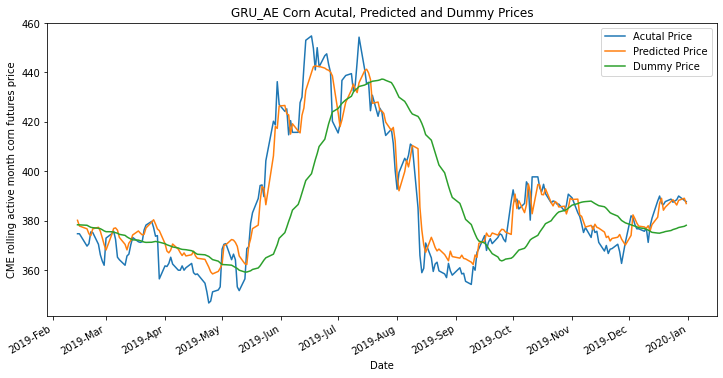

In [ ]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

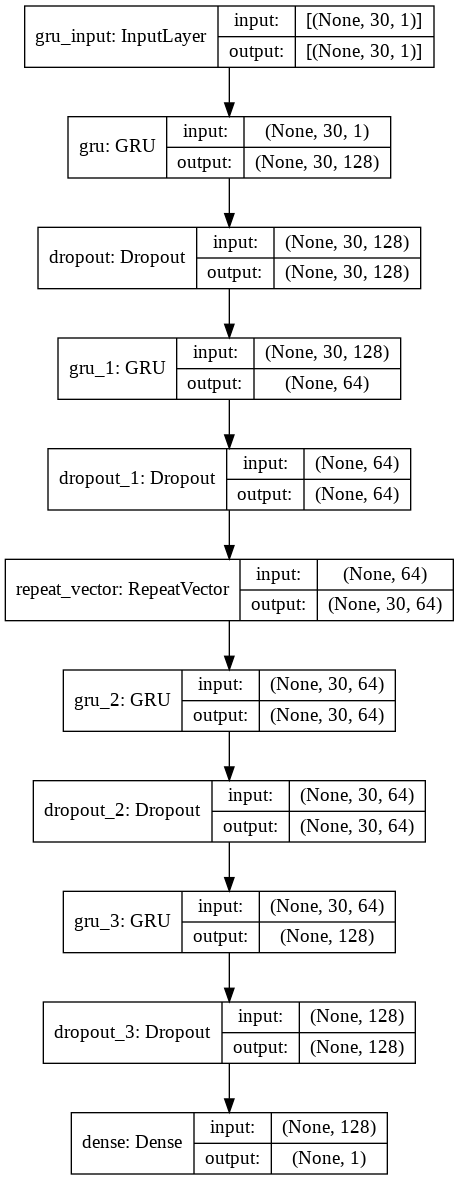

In [ ]:
plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.00450134381548987
RMSE:  0.06709205478661293
MAE:  0.051096262136200166
Dummy MSE:  0.041446864361575214
Dummy RMSE:  0.20358502980714277
Dummy MAE:  0.15160472972972977


In [ ]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/
INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_AE_Corn/assets
